## Identifying regional threshold

In this chapter, we will:

- define an Receiver Operating Characteristic Curve Analysis
- "cut" the MODIS NDSI data at every NDSI value and count the numbers that match the camera trap data
- inspect plot and select the best threshold 

To determine the best threshold, we will conduct a Receiver Operating Characteristic Curve Analysis. In this analysis, we "cut" the the MODIS NDSI data at every value and then count the number of corresponding 1s and 0s that match the camera trap 1s and 0s. We will then take threshold that maximizes the true positive and minimizes the false positives. For example, if we cut the MODIS data at NDSI value = 0, then all values >1 would be assigned "1", and a value of 0 would be assigned "0". We then check these values with the camera trap data to see if the 1s from the satellite match when the camera trap label is also 1, and the same for the 0 values. In the case of a threshold equal to 0, there would be many values in the NDSI values that we say are 1 (i.e., "snow") but don't have snow in the camera trap image. These are called *false positives*. We hope to minimize this number. The same is true on the other end of the extreme. If we pick a threshold too high, we have *false negatives*. We hope to find the threshold in the middle that balances these two quantities. 

We find the threshold that balances our false positives and false negatives by plotting the true positive rate against the false positive rate at each threshold value, creating **receiver-operating-characteristic (ROC) curve**.

In [2]:
# import necessary packages 

# data management
import pandas as pd
import numpy as np

# model development
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# visualization
import matplotlib.pyplot as plt

First we will load in our data, using the *pandas* library. We saw this in Chapter 2, and two review we have two columns that we are interested in, "SnowCover" which is the camera-labeled snow cover value and "NDSImodis," which is the satellite-derived snow value. 

In [3]:
#import dataset from CSV file on Github
url = "/Users/catherinebreen/code/Chapter2/ntbk_data/data.csv" ### update with other data

data = pd.read_csv(url)
data.head()

,cameraID,Date,SnowCover,NDSImodis
0,X,1/7/18,1,61
1,X,1/7/18,0,48
2,X,1/19/18,1,59
3,X,1/7/18,1,53
4,X,1/19/18,1,73


We will assign the two columns of interest (e.g., SnowCover and NDSImodis) to variables X and y. We will also do some reshaping to get it in the format for later modelling and graphing applications

In [8]:
#define the predictor variables and the response variable
X = np.array(data['NDSImodis']).reshape(-1,1)
y =  np.array(data['SnowCover']).reshape(-1,1) 
print(f"X: {X}")
print(f"y: {y}")

X: [[61]
 [48]
 [59]
 ...
 [73]
 [72]
 [59]]
y: [[1]
 [0]
 [1]
 ...
 [1]
 [1]
 [1]]


Below we plot the MODIS NDSI values and the camera trap values to get a sense of the range of MODIS NDSI values for camera trap values 0 and 1. We see that when the camera trap image is labeled 0 (no snow), there are fewer MODIS NDSI values above ~70. With this number of data points, it's hard to see, but when the camera label is equal to 1, there are fewer data points below ~50. We will do a ROC analysis to systemically decide what is the best threshold to separate these values.

([<matplotlib.axis.YTick at 0x29388f490>,
 [Text(0, 0, ''), Text(0, 0, '')])

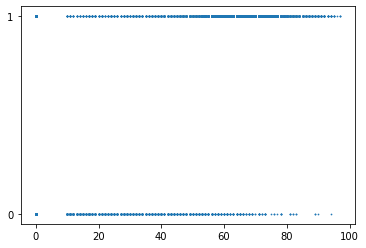

In [15]:
# plot X and y, setting marker size to 2. 
plt.scatter(X,y, s = 0.5)

# assign y labels
plt.yticks([0,1])

This plot also shows that we are trying to continous MODIS NDSI snow cover data (i.e., 0-100) and categorial camera-labelled data (i.e., 0 and 1). Logistic regressions predict categories from continous data, and are often used when assessing thresholds for classification tasks. To set-up our ROC analysis we first fit a logistic model of the camera labels from the satellite values. 

In [17]:
#instantiate the model
log_regression = LogisticRegression()

#fit the model using the training data
log_regression.fit(X, y)

/Users/catherinebreen/miniconda3/envs/cv4e/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

Next, we calculate the true positive rate and the false positive rate and create a ROC curve using the Matplotlib data visualization package. We use the function to *predict_proba* from python's *scikitlearn* package to get the probability of whether a MODIS NDSI value is a 0 or a 1. This results in an a *n* x 2 array, where each row has two columns representing the probability of either a 0 or a 1. In a binary classification problem, the two columns for each row add up to 1. We only need the second column, because we are trying to calculate our true positive and false positive rates from our positive class. We can then use the function *metrics.roc_curve* also from *scikitlearn* to calculate  the false positive rate (fpr), true positive rate (tpr), and threshold probability (threshold_prob.)

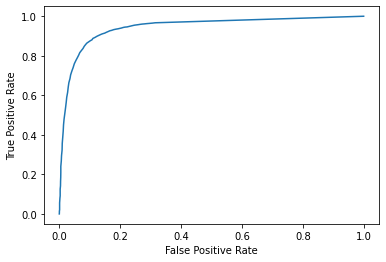

In [22]:
#define metrics
y_pred_proba = log_regression.predict_proba(X)[::,1]
fpr, tpr, threshold_prob = metrics.roc_curve(y,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The top left corner of the ROC curve is known as Youden's Index, or the maximum difference between the true positive and false postive rate (Youden, 1950). Because it weighs both true positive and false positive rates equally, it is considered the optimum threshold for a classifier when there is equal preference for both classes (Liu, 2012).

We can calculate that by identifying MODIS NDSI value that maximizes FPR and TPR. So far, however, we have only TPR, FPR, and threshold probability, but our ROC function doesn't report which TPR and FPR rate correspond to which MODIS NDSI value. We will have to back-track the MODIS NDSI snow values from the probability.  

In [29]:
# metrics from roc curve 
df = pd.DataFrame({'tpr':tpr, 'fpr': fpr, 'threshold_probablity':threshold_prob})

## backtrack threshold value from probabilty 
df['threshold_log_odds'] = np.log(df['threshold_probablity'] / (1 - df['threshold_probablity']))

#
df['threshold_score'] = (df['threshold_log_odds'] - log_regression.intercept_[0]) / (log_regression.coef_[0])
 #logit_model$coefficients[1]) / logit_model$coefficients[2]

df.head()

/Users/catherinebreen/miniconda3/envs/cv4e/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,tpr,fpr,threshold_probablity,threshold_log_odds,threshold_score
0,0.000000,0.000000,1.995653,NaN,NaN
1,0.000587,0.000000,0.995653,5.433879,97.0
2,0.000783,0.000000,0.995269,5.348837,96.0
3,0.001762,0.000000,0.994851,5.263796,95.0
4,0.003327,0.000263,0.994397,5.178754,94.0


Now we can look up the corresponding threshold value by find the the index that corresponds to the maximum difference between TPR and FPR. After finding the index, we can inspect the full row to see our optimal threshold. 

In [30]:
best_J_index = np.argmax(tpr-fpr)
print(df.iloc[best_J_index])

tpr                      0.887845
fpr                      0.110528
threshold_probablity     0.661851
threshold_log_odds       0.671555
threshold_score         41.000000
Name: 56, dtype: float64


In this case, the maximum difference between our TPR and FPR was when our TPR was 88% and our FPR was 11%. Thus, Youden's Index corresponded to a MODIS NDSI snow cover value of 41. We can use that value to create our map. Interestingly, 41 is almost identical to the threshold of 40 used in previous MODIS products (Hall et al., 2019). We can recreate our map from Chapter 2, but instead of the full range of MODIS NDSI snow cover values, we now have a map of snow and no snow using 41 as the threshold.

<img src="ntbk_data/binary_map.png" alt="binary map" />

Depending on mapping needs, other threshold values could be used. For example, higher thresholds for snow might be desirable when making maps of the first "snow on" date in the fall to prioritize snow detection. Other studies have found adjustments to the threshold can increase regional accuracy (Chokmani et al., 2010, Luo et al., 2022). 

We can inspect the table to identify different thresholds with other corresponding TPR and FPR rates. For example, here is a subset of the table with some rows above and below our threshold of 41. 

In [32]:
df[50:60]

,tpr,fpr,threshold_probablity,threshold_log_odds,threshold_score
50,0.847915,0.081911,0.765272,1.181804,47.0
51,0.857115,0.086637,0.749653,1.096763,46.0
52,0.863770,0.090312,0.733357,1.011721,45.0
53,0.869446,0.095563,0.716401,0.926680,44.0
54,0.876101,0.101864,0.698810,0.841638,43.0
55,0.880799,0.107377,0.680614,0.756597,42.0
56,0.887845,0.110528,0.661851,0.671555,41.0
57,0.893326,0.117879,0.642565,0.586514,40.0
58,0.898219,0.123129,0.622805,0.501472,39.0
59,0.901938,0.128118,0.602629,0.416431,38.0


Would a balance between snow and no snow be appropriate in your study area? 

In the next section, we will summarize our findings and suggest ways that this could be applied in your study area. 